In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
import sklearn.neural_network as nn
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# <u> 1. Data Set Description <u>

<ul>
<li> <b> out </b>is a dataset of the status of animals as they <b>leave</b> Austin Animal Center from October, 2013 to March, 2016. Each row represents an animal. </li>
<li> <b> intake </b> is a dataset of the status of animals as they <b>arrive</b> at the Austion Animal Center from October, 2013 to present. Each row represents an animal.</li>
<li> <b> df </b> is the merged dataset between <b> out </b> and <b> intake </b>.
</ul>

Important columns in <b> out </b> are:
<ol>
<li> <b>OutcomeType</b>: status of the animal when it left the animal center </li>
<li> <b>DateTime</b>: timestamp when the animal leave the animal center </li>
<li> <b>AnimalType</b>: type of animal </li>
<li> <b>SexuponOutcome</b>: sex and neuter/spay information </li>
<li> <b>AgeuponOutcome</b>: age of the animal in terms of weeks, months, or years when they leave the shelter
<li> <b>Breed</b>: breed of the animal </li>
<li> <b>Color</b>: color of the animal </li>
</ol>

Important columns in <b> intake </b> are:
<ol>
<li> <b>DateTime</b>: timestamp when the animal arrive at the animal center </li>
<li> <b>Intake Condition</b>: Condition of the animal when arrive at the shelter</li>
<li> <b>AgeuponIntake</b>: age of the animal in terms of weeks, months, or years when they arrive the shelter
</ol>

Data in <b>out</b> data set is recorded from 2013-10-01 to 2016-02-21, while data in <b>intake</b> data set keeps updating since 2013-10-01. We need to match the time of the two dataframe before merging. 

In [80]:
out = pd.read_csv('train.csv') 
intake = pd.read_csv('Austin_Animal_Center_Intakes.csv')

In [81]:
intake = intake[intake.DateTime.astype(np.datetime64) < '2016-02-22'] 

In [82]:
# Merge the two datasets so we have more features to work with
df = out.merge(intake,left_on ='AnimalID', right_on ='Animal ID', how='left')

In [83]:
# Remove the duplicate columns and unnecessary information for analysis
df = df.drop(columns = ['OutcomeSubtype','Animal ID','Name_y','MonthYear','Found Location','Animal Type',\
                   'Sex upon Intake','Breed_y','Color_y','Intake Type'])
# Rename the columns
df.columns =['AnimalID',
 'Name',
 'DateTimeOut',
 'OutcomeType',
 'AnimalType',
 'SexuponOutcome',
 'AgeuponOutcome',
 'Breed',
 'Color',
 'DateTimeIn',
 'IntakeCondition',
 'AgeuponIntake'  ]

In [84]:
# Convert the datetime format
df['DateTimeOut'] = df.DateTimeOut.astype(np.datetime64)
df['DateTimeIn'] = df.DateTimeIn.astype(np.datetime64)

In [85]:
# We drop the rows with NAs in take in time. 
df = df[df.DateTimeIn.isna() == False]

In [86]:
df = df.sort_values(by = ['DateTimeIn','DateTimeOut'])

In [109]:
df.head(1)

,Year_in,month_in,Dog,AgeOut_month,AgeIn_month,PureBreed,Num_of_Color,SamePetNum_bymonth,mean_age_last20,older_last20,...,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,IntakeCondition_Aged,IntakeCondition_Feral,IntakeCondition_Injured,IntakeCondition_Normal,IntakeCondition_Nursing,IntakeCondition_Other,IntakeCondition_Pregnant,IntakeCondition_Sick
2603,2013,10,0,0.25,0.25,0.0,2,365,NaN,0,...,0,1,0,0,0,1,0,0,0,0


# <u> 2. Data Preparation </u>

In [87]:
#get columns from the Datetime column and separate out the year and month
df['Year_in'] = df.DateTimeIn.astype(np.datetime64).dt.year
df['month_in'] = df.DateTimeIn.astype(np.datetime64).dt.month

In [88]:
# Create a column called 'Dog' based on 'AnimalType': 1 if is a dog, 0 if is a cat.
df['Dog'] = df.AnimalType.apply(lambda x: 1 if x == 'Dog'
                       else 0 )

In [89]:
# There is 'Unknown' in 'SexuponOutcome', so NA values are included into this group.
df.loc[df.SexuponOutcome.isna() , 'SexuponOutcome'] = 'Unknown'

In [90]:
# Rows without age when take out are removed
df = df[df.AgeuponOutcome.isna()==False]

In [91]:
# Uniform the unit of age_out to 'month'
df['AgeOut_month'] = df.AgeuponOutcome.apply(lambda x: int(x[0:2])/30 if 'day' in x
                                        else int(x[0:2])/4 if 'week' in x
                                        else 12*int(x[0:2]) if 'year' in x
                                        else int(x[0:2]))

In [92]:
# Uniform the unit of age_in to 'month'
df['AgeIn_month'] = df.AgeuponIntake.apply(lambda x: int(x[0:2])/30 if 'day' in x
                                        else int(x[0:2])/4 if 'week' in x
                                        else 12*int(x[0:2]) if 'year' in x
                                        else int(x[0:2]))

In [93]:
# Split Breed to mix or pure.
df.loc[df.Breed.str.contains('Mix'), 'PureBreed'] = 0
df.loc[df.Breed.str.contains('Mix') == False, 'PureBreed'] = 1

In [94]:
# Count the number of color for each pet
df['Num_of_Color'] = df.Color.apply(lambda x: 3 if ('Tricolor' in x) | (x.count('/')==2)
                else 1 if x.count('/')==0 \
                else 2 if x.count('/')==1 
                else 4)

In [95]:
# NA in IntakeCondition is set to be 'Normal'
df.loc[df.IntakeCondition.isna(), 'IntakeCondition'] = 'Normal'

In [96]:
# Calculate the number of cat/dogs arrived in the same month
df['SamePetNum_bymonth'] =  df.groupby(['Year_in','month_in','Dog'])['AnimalID'].transform(size)

In [97]:
# average age of the last 20 cats/dogs taken in
df['prev_age'] = df.groupby('Dog').AgeIn_month.shift(1)
df['mean_age_last20'] = df.groupby('Dog').prev_age.apply(lambda x: x.rolling(20).mean())
df['older_last20'] = (df.AgeIn_month > df.mean_age_last20) *1

In [98]:
# average age of the cats/dogs taked in in the same month 
df['month_mean_age'] = df.groupby(['Dog','Year_in', 'month_in']).AgeIn_month.transform(mean)
df['older_month_mean'] = (df.AgeIn_month > df.month_mean_age) *1

###### We define a positive outcome(=1) if an animal is adopted or returned to owner, a negative outcome(=0) for other situations.

In [99]:
df['Outcome'] = df.OutcomeType.apply(lambda x: 
                        1 if (x == 'Adoption')|(x == 'Return_to_owner')
                       else 0)

In [100]:
df.columns 

Index(['AnimalID', 'Name', 'DateTimeOut', 'OutcomeType', 'AnimalType',
       'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'DateTimeIn',
       'IntakeCondition', 'AgeuponIntake', 'Year_in', 'month_in', 'Dog',
       'AgeOut_month', 'AgeIn_month', 'PureBreed', 'Num_of_Color',
       'SamePetNum_bymonth', 'prev_age', 'mean_age_last20', 'older_last20',
       'month_mean_age', 'older_month_mean', 'Outcome'],
      dtype='object')

In [101]:
# Get Dummies for all categorical columns
df = pd.get_dummies(df, columns= ['SexuponOutcome', 'IntakeCondition'])

In [102]:
# Drop the non-numeric columns
df = df.drop(columns=['AnimalID','Name','DateTimeOut','OutcomeType','AnimalType',\
                      'AgeuponOutcome','Breed','Color', 'DateTimeIn', 'AgeuponIntake','prev_age'])


# <u> 3. Machine Learning: Decision Tree </u>

We used decision tree to figure out important features result the animal outcome. This model will be used when an animal is taken in to predict the possible outcome for the anima and provide some guidence for animal outcome improvement.

In [110]:
#drop the NAs created by rolling
df2 = df[~df.mean_age_last20.isna()]

In [111]:
#create the X for decision tree
X = df2.drop(columns=['Outcome'])

In [112]:
#create the Y for decision tree where Y is a dummy variable
Y = df2['Outcome']

In [113]:
dt = tree.DecisionTreeClassifier(max_depth =2)

In [114]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

##### Some of the findings in the following tree is that:
<ol>
<li>  If the animal leave the shelter at an age of 1.625 month or younger and if the animal is a spayed female, the animal is more likely to have a positive outcome.</li>
<li>  If the animal leave the shelter at an age of 1.625 month or younger  and if the animal is not a spayed female, the animal is less likely to have a positive outcome.</li>
<li>  If the animal leave the shelter at an age older than 1.625 month and if the animal is an intact female, it is less likley to have a positive outcome.</li>
<li>  If the animal leave the shelter at an age older than 1.625 month and if the animal is not an intact female, it is more likley to have a positive outcome.</li>

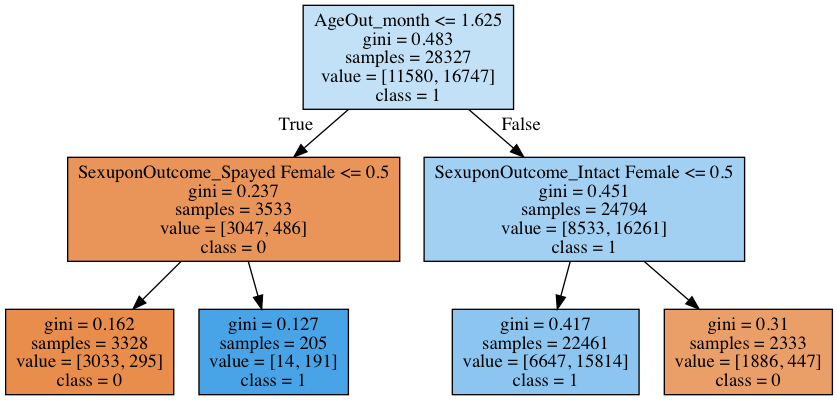

In [115]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

# <u> 4. Interesting Finding Summary </u>

In general, animals older than 1.625 months are more likely to be adopted or returned to owner. However, for those animals who are spayed female, their probability to be adopted or returned at a younger age(<=1.625 months) are very high.  

# <u> 5. Validity of the Finding </u>

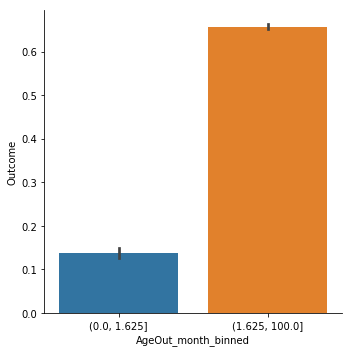

In [117]:
df['AgeOut_month_binned'] = pd.cut(df.AgeOut_month, bins= [0,1.625,100])
sns.catplot(data = df, y = 'Outcome', x='AgeOut_month_binned', kind = 'bar')

In general, we expect people to adopt puppies/kittens that are older than 8 weeks or so.

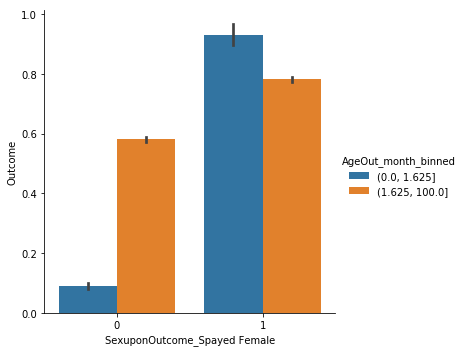

In [118]:
sns.catplot(data = df, y = 'Outcome', hue='AgeOut_month_binned', x='SexuponOutcome_Spayed Female', kind = 'bar')

However, we find that it's not the case in this dataset for animals that are spayed female. If the animal's gender is spayed female, 
<ul>
<li> the probability of having a positive outcome at a younger age (less than 1.625 month old) increases drastically in comparison to puppy/kitten of other gender.
<li> the probability of having a positive outcome at a younger age(less than 1.625 month) is even higher than spayed female older than 1.625 month old.

# <u> 6.  Managerial Insights</u>

From the result of the decision tree and the visualizations we conclude that animals who are older than 1.625 month tend to have a much higher chance of having a positive outcome (adopted or returned to owner). This can be caused by a few things:
<ul>
<li> Newly borned animals have a high rate of death if not raised properly. So after the first several month, people can make sure the puppies/kittens are healthy enough when they arrive home.  
<li> Animals older than 1.625 month are a little more mature and have learnt basic living skills. They will be easier for owners to raise or train.

However, as we dig further into the data, we see that the probability of a positive outcome for a younger animal (less than or equal to 1.625 month) will surpass the probability of an older animal (older than 1.625 month) in case it is a spayed female. 

This counters the idea we had in mind (more matured animals are more likely to get adopted/returned due to reasons mentioned above), and we came up with an explanation:

<li> The cost of spaying a female animal is quite high. Owners who lost their spayed pet are more likely to find them back. For people considering adoption, if they get a young puppy/kitten, they tend to get them neutered/spayed in the future. A young spayed female would greatly reduce owners' cost in the future and thus be preferred. 


Based on this finding, we recommend Austin Animal Center to spay young female animals as this would greatly increase their probability of a positive outcome. This will be benefical to the shelter in the long run, since younger animals are much more costly for daily maintainence and they take up a lot of capacity for the shelter if not adopted. 